In [12]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [42]:
# Load experimental results from files.

from pathlib import Path
import re
import yaml
from yaml import SafeLoader

EXP_PATH = "/home/hazrael/GitRepositories/storalloc/storalloc-gitlab/simulation/results"
EXP_NAME = "exp__07-Dec-22_10-11_het32TB_1"
EXP_FILE = "exp__split_200G_worst_case_infra32TBhet_multi_node_multi_disk_IOJobs.yml"

full_path = f"{EXP_PATH}/{EXP_NAME}/{EXP_FILE}"
print(f"Using file: {full_path}")

exp_data = []

infra_pattern = re.compile(r"infra\d+TB")
system_pattern = re.compile(r"(single|multi)(_[a-z]+){3}")
algo_pattern = re.compile(r"(split_200G)_?(\S+)_infra\d+TBhet")

with open(full_path, "r", encoding="utf-8") as yaml_file:
    exp = yaml.load(yaml_file, Loader=SafeLoader)
    exp["full_name"] = Path(full_path).stem.split('__')[1]
    exp["infra"] = infra_pattern.findall(exp["full_name"])[0]
    exp["system"] = system_pattern.search(exp["full_name"])[0]
    exp["algo"] = algo_pattern.search(exp['full_name'])[2]
    exp_data.append(exp)

Using file: /home/hazrael/GitRepositories/storalloc/storalloc-gitlab/simulation/results/exp__07-Dec-22_10-11_het32TB_1/exp__split_200G_worst_case_infra32TBhet_multi_node_multi_disk_IOJobs.yml


In [43]:
# Load them (almost) unprocessed into a DataFrame

import pandas as pd

df_data = pd.DataFrame(exp_data)
df_data

,alloc_delayed_requests_count,alloc_split_requests_count,alloc_split_requests_duration,alloc_split_requests_gb,delayed_requests_count,failed_split_requests_count,max_concurrent_allocations,nodes,refused_delayed_requests_count,refused_split_requests_count,...,simulation_fallbacks_count,split_requests_count,split_threshold_gb,tt_allocated_gb,tt_deallocated_gb,tt_delay_time_minutes,full_name,infra,system,algo
0,0,804,13683503.0,1.263635e+06,0,68,206,"[{'disks': [{'capacity': 8000, 'id': 0, 'last_...",0,1,...,68,872,200,1.329493e+06,1.329493e+06,0,split_200G_worst_case_infra32TBhet_multi_node_...,infra32TB,multi_node_multi_disk,worst_case


In [83]:
# DATASET POST-PROCESSING
# Compute some means (per node / disk) extracted from the "nodes" column 
# and add them as new columns in the original dataset

# New columns
mean_node_alloc = [] # extracted from existing field
max_node_alloc = []
mean_node_utilisation = []
max_node_utilisation = []
tt_allocated_percent = []

for idx, row in df_data.iterrows():
    
    tt_allocated_percent.append(int((row["tt_allocated_gb"] * 100) / 1607838))

    acc_mean_node_alloc = []
    acc_max_disk_alloc = []
    acc_mean_cap_utilisation = []
    acc_max_cap_utilisation = []

    ## NODES
    for node in row["nodes"]:

        acc_mean_node_alloc.append(node["mean_nb_alloc"])        
        mean_disk_alloc = []
        mean_cap_utilisation = []

        # DISKS
        for disk in node["disks"]:
            acc_max_disk_alloc.append(disk["max_alloc"])
            mean_disk_alloc.append(disk["mean_nb_alloc"])
            acc_max_cap_utilisation.append(disk["max_cap_utilisation"])
            mean_cap_utilisation.append(disk["mean_capacity_utilisation"])
        
        mean_disk_alloc = pd.Series(mean_disk_alloc).mean()
        acc_mean_cap_utilisation = pd.Series(mean_cap_utilisation).mean()
        
    # Building future column for DataFrame
    mean_node_alloc.append(pd.Series(acc_mean_node_alloc).mean())
    max_node_alloc.append(max(acc_max_disk_alloc))
    mean_node_utilisation.append(pd.Series(acc_mean_cap_utilisation).mean())
    max_node_utilisation.append(max(acc_max_cap_utilisation))
    
df_data["mean_node_alloc"] = mean_node_alloc
df_data["max_node_alloc"] = max_node_alloc
df_data["mean_node_utilisation"] = mean_node_utilisation
df_data["max_node_utilisation"] = max_node_utilisation
df_data["tt_allocated_percent"] = tt_allocated_percent

rows, cols = df_data.shape
if cols < 30:
     raise ValueError("That's weird, there should be more columns now (about 30)")
        
df_data.head()

,alloc_delayed_requests_count,alloc_split_requests_count,alloc_split_requests_duration,alloc_split_requests_gb,delayed_requests_count,failed_split_requests_count,max_concurrent_allocations,nodes,refused_delayed_requests_count,refused_split_requests_count,...,tt_delay_time_minutes,full_name,infra,system,algo,mean_node_alloc,max_node_alloc,mean_node_utilisation,max_node_utilisation,tt_allocated_percent
0,0,804,13683503.0,1.263635e+06,0,68,206,"[{'disks': [{'capacity': 8000, 'id': 0, 'last_...",0,1,...,0,split_200G_worst_case_infra32TBhet_multi_node_...,infra32TB,multi_node_multi_disk,worst_case,0.726333,30,1.285,99.902,82


In [84]:
df_data.describe()

,alloc_delayed_requests_count,alloc_split_requests_count,alloc_split_requests_duration,alloc_split_requests_gb,delayed_requests_count,failed_split_requests_count,max_concurrent_allocations,refused_delayed_requests_count,refused_split_requests_count,refused_split_requests_duration,...,split_requests_count,split_threshold_gb,tt_allocated_gb,tt_deallocated_gb,tt_delay_time_minutes,mean_node_alloc,max_node_alloc,mean_node_utilisation,max_node_utilisation,tt_allocated_percent
count,1.0,1.0,1.0,1.000000e+00,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.000000e+00,1.000000e+00,1.0,1.000000,1.0,1.000,1.000,1.0
mean,0.0,804.0,13683503.0,1.263635e+06,0.0,68.0,206.0,0.0,1.0,86627.0,...,872.0,200.0,1.329493e+06,1.329493e+06,0.0,0.726333,30.0,1.285,99.902,82.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,804.0,13683503.0,1.263635e+06,0.0,68.0,206.0,0.0,1.0,86627.0,...,872.0,200.0,1.329493e+06,1.329493e+06,0.0,0.726333,30.0,1.285,99.902,82.0
25%,0.0,804.0,13683503.0,1.263635e+06,0.0,68.0,206.0,0.0,1.0,86627.0,...,872.0,200.0,1.329493e+06,1.329493e+06,0.0,0.726333,30.0,1.285,99.902,82.0
50%,0.0,804.0,13683503.0,1.263635e+06,0.0,68.0,206.0,0.0,1.0,86627.0,...,872.0,200.0,1.329493e+06,1.329493e+06,0.0,0.726333,30.0,1.285,99.902,82.0
75%,0.0,804.0,13683503.0,1.263635e+06,0.0,68.0,206.0,0.0,1.0,86627.0,...,872.0,200.0,1.329493e+06,1.329493e+06,0.0,0.726333,30.0,1.285,99.902,82.0
max,0.0,804.0,13683503.0,1.263635e+06,0.0,68.0,206.0,0.0,1.0,86627.0,...,872.0,200.0,1.329493e+06,1.329493e+06,0.0,0.726333,30.0,1.285,99.902,82.0


In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_theme = {
    "context": "paper",            
    "palette": "Paired", 
    "style": "whitegrid", 
    "rc": {
        "axes.spines.right":False, 
        "axes.spines.top": False,
    }
}

categorical_theme_2 = {
    "context": "paper",            
    "palette": "husl", 
    "style": "whitegrid", 
    "rc": {
        "axes.spines.right":False, 
        "axes.spines.top": False,
    }
}

categorical_theme_disk = {
    "context": "paper",            
    "palette": "colorblind", 
    "style": "whitegrid", 
}

In [96]:
print(f"# Total number of requests: {df_data['requests_count'].values}")
print(f"# Simulation duration (internal time): {df_data['sim_duration'].values[0] / 60 / 60 / 24} days")
print(f"# Max concurrent allocations considering all nodes at once (whole simulation): {df_data['max_concurrent_allocations'].values}")
print(f"# Max node utilisation  (%, whole simulation): {df_data['max_node_utilisation'].values[0]}%")
print(f"# Total allocated volume (GB, whole simulation): {df_data['tt_allocated_gb'].values[0]/1000/1000:0.4} PB")
print(f"# Total allocated volume (% of requested, whole simulation): {df_data['tt_allocated_percent'].values[0]}%")

print()

print(f"# Number of split requests: {df_data['split_requests_count'].values[0]}")
print(f"# Number of allocated split requests: {df_data['alloc_split_requests_count'].values[0]}")
print(f"# Number of failed split requests: {df_data['failed_split_requests_count'].values[0]}")
print(f"# Number of refused split requests: {df_data['refused_split_requests_count'].values[0]}")

print()

print(f"# Mean number of concurrent allocations per node (whole simulation): {df_data['mean_node_alloc'].values[0]}")
print(f"# Max number of concurrent allocations on any single node: {df_data['max_node_alloc'].values[0]}")

# Total number of requests: [31160]
# Simulation duration (internal time): 364.76342592592596 days
# Max concurrent allocations considering all nodes at once (whole simulation): [206]
# Max node utilisation  (%, whole simulation): 99.902%
# Total allocated volume (GB, whole simulation): 1.329 PB
# Total allocated volume (% of requested, whole simulation): 82%

# Number of split requests: 872
# Number of allocated split requests: 804
# Number of failed split requests: 68
# Number of refused split requests: 1

# Mean number of concurrent allocations per node (whole simulation): 0.7263333333333334
# Max number of concurrent allocations on any single node: 30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


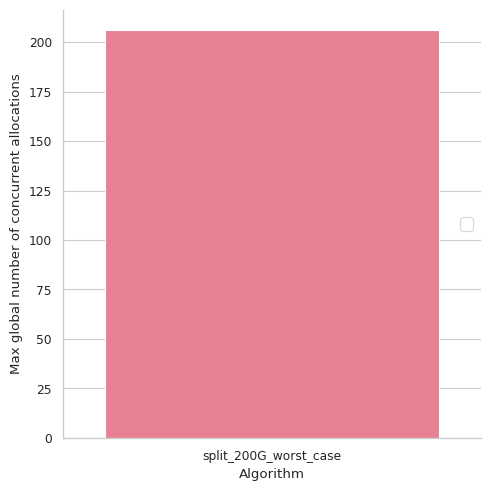

In [29]:
sns.set_theme(**categorical_theme_2)

# --- MAX CONCURRENT ALLOCATIONS (ALL NODES)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="max_concurrent_allocations",
    height=5, legend=False
)
g.set(ylabel="Max global number of concurrent allocations", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


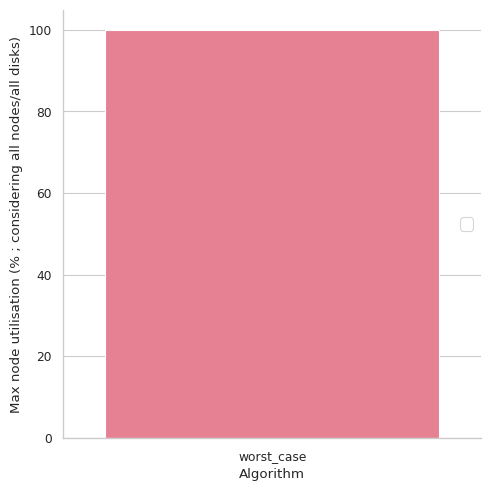

In [47]:
sns.set_theme(**categorical_theme_2)

# --- MAX NODE UTILISATION (ALL NODES)
# For platform with underfit capacity (8/16 TB), every algorithm reaches about 100% max node utilisation (see above how this is computed) : 
# it means at least 1 disk per node has reached 100% utilisation

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="max_node_utilisation",
    height=5, legend=False
)
g.set(ylabel="Max node utilisation (% ; considering all nodes/all disks)", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


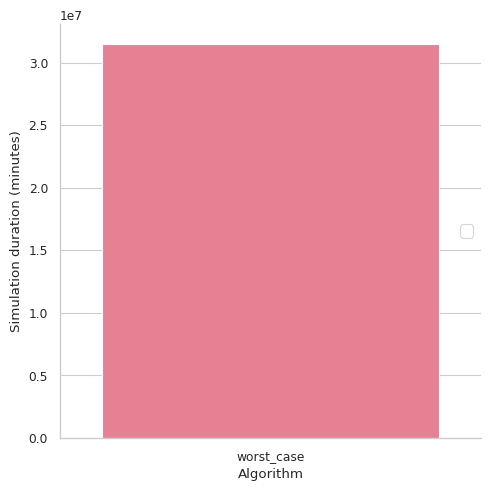

In [49]:
sns.set_theme(**categorical_theme_2)

# --- SIMULATION DURATION (ALL NODES)
# For every experiments, the entire dataset has been processed (no algorithm failed/crashed early)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="sim_duration",
    height=5, legend=False
)
g.set(ylabel="Simulation duration (minutes)", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


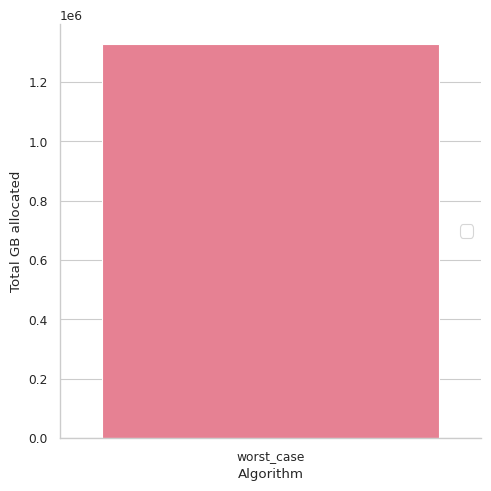

In [51]:
sns.set_theme(**categorical_theme_2)

# --- TOTAL GB ALLOCATED (ALL NODES)
# When there's not enough space, worst_fit and worst_case seem to be more resilient than rr and random.

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="tt_allocated_gb",
    height=5, legend=False
)
g.set(ylabel="Total GB allocated", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


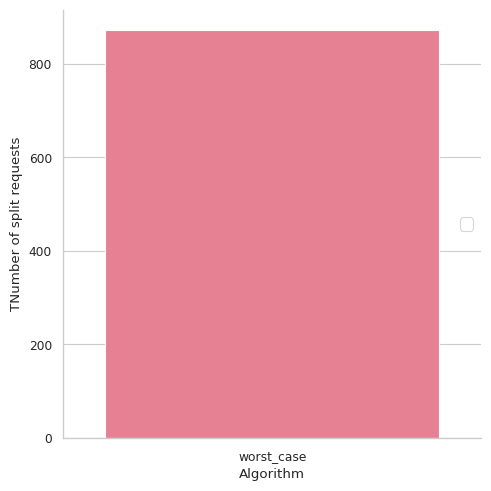

In [53]:
sns.set_theme(**categorical_theme_2)

# --- NUMBER OF SPLIT REQUESTS
# When there's not enough space, worst_fit and worst_case seem to be more resilient than rr and random.

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="split_requests_count",
    height=5, legend=False
)
g.set(ylabel="TNumber of split requests", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


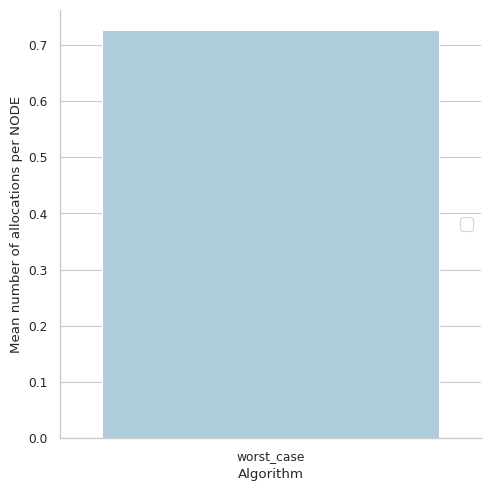

In [54]:
# [1] --- Mean number of allocations per node, for every algorithm => need to check hoaw this is computed...
# -> IF it's correct, it correspond to the mean number of allocation over the entire dataset period 
# Computed in the following way : if a disk has 1 allocation during 5s, and the dataset duration is 10s in total, then over the dataset duration period, this
# disk has (5s*1a + 5s*0a) / 10s) = 0.5. Our standard dataset is very sparse (there can be only a handful of allocations per day, lasting for as short 
# as a few minutes, and the dataset covers a whole year... so the means are quite low)

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="mean_node_alloc",
    height=5, legend=False
)
g.set(ylabel="Mean number of allocations per NODE", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

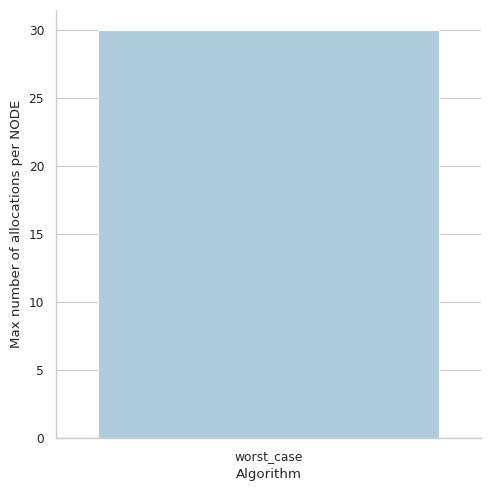

In [55]:
# [2] ---  Max number of allocations per node, for every algo (main parameters of the simulation are in its name)
# Corresponds to the max number of allocations for any single disk in the node. It can go very high because our dataset contains a period of 
# benchmarks around december 4th-7th, with huge number of very small and very short allocations each day.
# Worst_fit tends to have very high number of allocations for every kind of system, as it is its goal to always put allocations on the disk that already has
# the most.

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="max_node_alloc",
    height=5
)
g.set(ylabel="Max number of allocations per NODE", xlabel="Algorithm")

In [56]:
# [3] ---  Total number of scheduler failures, for every simulation
# Failures are of course dependent on the total capacity of the system. 
# Worst_case and round robin should be more resilient to failures but it's actually not really the case

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="",
    height=5, legend=False
)
g.set(ylabel="Number of scheduler failures per run", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

ValueError: Could not interpret input 'nb_of_scheduler_failures'

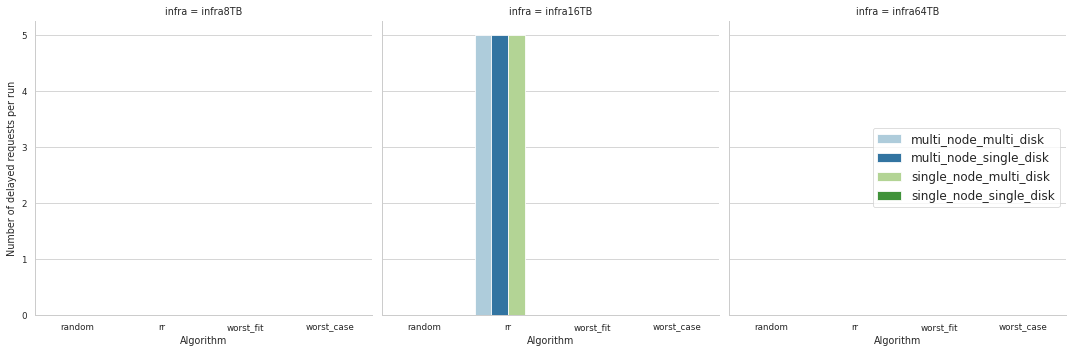

In [18]:
# [4] ---  Total number of delayed requests, for every simulation 
# (to be confirmed) only rr and worst_case are able to alert the scheduler that they didn't find a suitable choice, which allows for a retry with delayed 
# start_time. We see that worst_case is more prone to trigger retries with delays, but it also usually suffers from less failures than rr (as per previous graph)
# We might think that worst_case does a better job at knowing when a request won't be able to be allocated, and as per plot "TOTAL GB ALLOCATED (ALL NODES)",
# we can see more GB in total are allocated when using worst_case than when using rr

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="nb_of_delayed_requests", hue="system", col="infra",
    col_order=infra_order, order=algo_order, sharey="row",
    height=5, legend=False
)
g.set(ylabel="Number of delayed requests per run", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

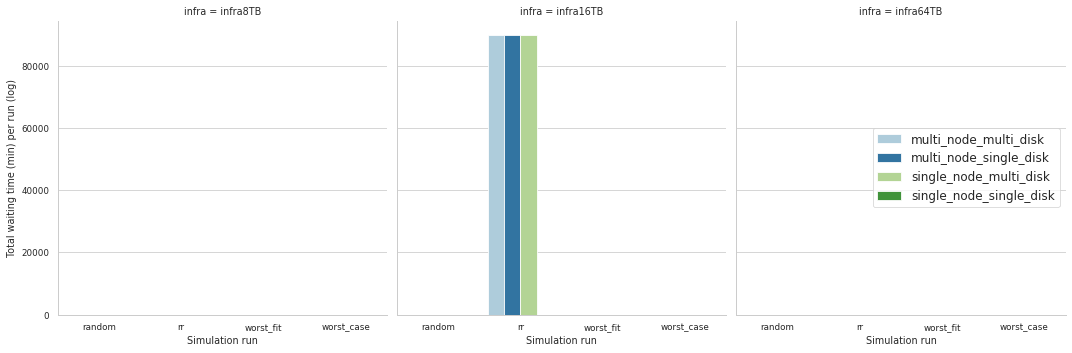

In [19]:
# [5] ---  Total cumulated waiting time for delayed requests, for every simulation
sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="tt_waiting_time_minutes", hue="system", col="infra",
    col_order=infra_order, order=algo_order, # sharey=False,
    height=5, legend=False
)
# g.set(yscale="log")
g.set(ylabel="Total waiting time (min) per run (log)", xlabel="Simulation run")
plt.legend(fontsize="12", loc="right")

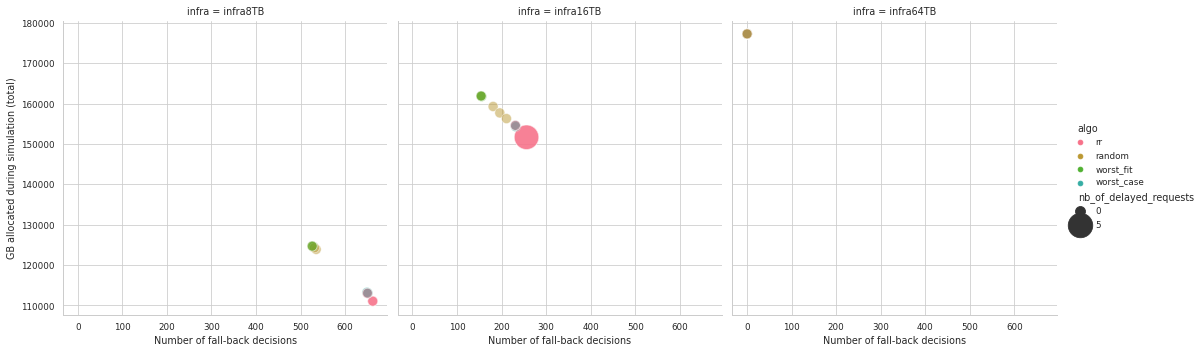

In [52]:
# # --- TOTAL GB ALLOCATED (ALL NODES) VS Scheduler fall-back 
# Suprisingly, the more scheduler failures, the less GB could be allocated ....
# More "interesting" findings:
# - configurations with high number of delayed requests are found both for "small" and "high" 
#   number of fall-back decision (actual number depends on the infra capacity) --> delaying requests 
#   for up to one hour doesn't seem to achieve better allocation results. We observe the same when considering 
#   total cumulated waiting time for delayed requests
# - the random algorithm (which doesn't permit delaying request because it always provides a 
#   seemingly valid server/node/disk tuple) clearly leads to most of the worst results


#sns.set(rc={'figure.figsize':(29.7,21)})
sns.set_theme(**categorical_theme_2)

#sns.set_style("whitegrid")
g = sns.relplot(
    x="nb_of_scheduler_failures", 
    y="tt_gb_allocated", 
    hue="algo", 
    size="nb_of_delayed_requests",
    #size="tt_waiting_time_minutes",
    # style="system",
    col="infra",
    col_order=infra_order,
    sizes=(100, 600), 
    alpha=.50,
    height=5, 
    data=df_data
)
g.set(
    xlabel="Number of fall-back decisions", 
    ylabel="GB allocated during simulation (total)"
)

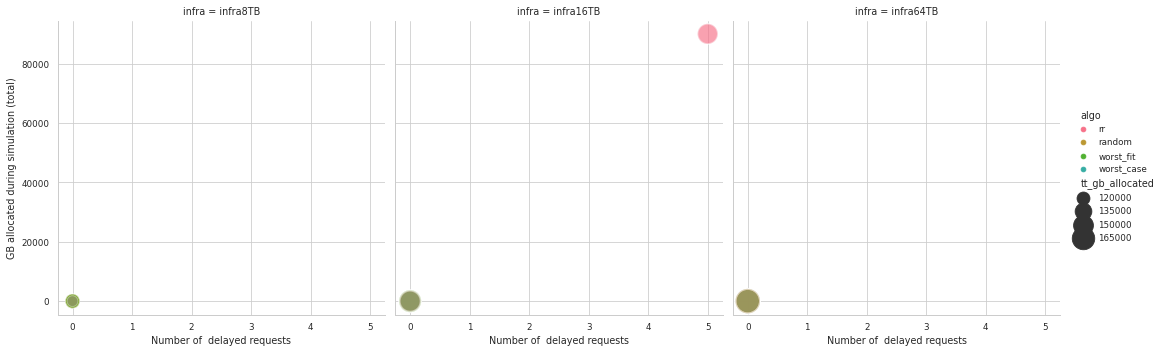

In [53]:
# # --- TOTAL GB ALLOCATED (ALL NODES) VS WAITING TIME DURING RETRIES

#sns.set(rc={'figure.figsize':(29.7,21)})
sns.set_theme(**categorical_theme_2)

#sns.set_style("whitegrid")
g = sns.relplot(
    x="nb_of_delayed_requests", 
    y="tt_waiting_time_minutes", 
    hue="algo", 
    size="tt_gb_allocated",
    # style="system",
    col="infra",
    col_order=infra_order,
    sizes=(100, 600), 
    alpha=.30,
    height=5, 
    data=df_data
)
g.set(
    xlabel="Number of  delayed requests", 
    ylabel="GB allocated during simulation (total)"
)

In [49]:
# [6] ---  Create a second dataset where each row is a disk (instead of having one simulation per row)

data_by_disk = {
    "run_name": [],
    "node_id": [],
    "disk_id": [],
    "full_disk_id": [],
    "disk_mean_nb_alloc": [],
    "disk_max_nb_alloc": [],
    "disk_mean_cap_percent": [],
    "disk_max_cap_percent": [],
    "disk_capacity": [],
    "infra": [],
    "system": [],
    "algo": []
}

for idx, row in df_data.iterrows():
    for node in row['nodes']:
        for disk in node["disks"]:
            data_by_disk["run_name"].append(row['full_name'])
            data_by_disk["node_id"].append(node['id'])
            data_by_disk["disk_id"].append(disk['id'])
            data_by_disk["full_disk_id"].append(f"{node['id']}:{disk['id']}")
            data_by_disk["disk_mean_nb_alloc"].append(disk['mean_nb_alloc'])
            data_by_disk["disk_max_nb_alloc"].append(disk['max_alloc'])
            data_by_disk["disk_mean_cap_percent"].append(disk['mean_capacity_utilisation'])
            data_by_disk["disk_max_cap_percent"].append(disk['max_cap_utilisation'])
            data_by_disk["disk_capacity"].append(disk['capacity'])
            data_by_disk["infra"].append(row['infra'])
            data_by_disk["system"].append(row['system'])
            data_by_disk["algo"].append(row['algo'])
    
data_by_disk = pd.DataFrame(data_by_disk)
data_by_disk

,run_name,node_id,disk_id,full_disk_id,disk_mean_nb_alloc,disk_max_nb_alloc,disk_mean_cap_percent,disk_max_cap_percent,disk_capacity,infra,system,algo
0,rr_infra16TB_multi_node_multi_disk_IOJobsOct,S-dd863b:0,0,S-dd863b:0:0,0.474,20,2.205,99.601,2000,infra16TB,multi_node_multi_disk,rr
1,rr_infra16TB_multi_node_multi_disk_IOJobsOct,S-dd863b:0,1,S-dd863b:0:1,0.507,20,2.348,97.135,2000,infra16TB,multi_node_multi_disk,rr
2,rr_infra16TB_multi_node_multi_disk_IOJobsOct,S-dd863b:1,0,S-dd863b:1:0,0.508,20,2.275,99.389,2000,infra16TB,multi_node_multi_disk,rr
3,rr_infra16TB_multi_node_multi_disk_IOJobsOct,S-dd863b:1,1,S-dd863b:1:1,0.480,20,2.203,97.520,2000,infra16TB,multi_node_multi_disk,rr
4,rr_infra16TB_multi_node_multi_disk_IOJobsOct,S-dd863b:2,0,S-dd863b:2:0,0.550,20,2.457,99.847,2000,infra16TB,multi_node_multi_disk,rr
...,...,...,...,...,...,...,...,...,...,...,...,...
295,worst_fit_infra8TB_single_node_single_disk_IOJ...,S-57013a:0,0,S-57013a:0:0,4.873,82,5.791,100.000,8000,infra8TB,single_node_single_disk,worst_fit
296,rr_infra64TB_single_node_single_disk_IOJobsOct,S-729a6e:0,0,S-729a6e:0:0,4.907,292,0.734,45.588,64000,infra64TB,single_node_single_disk,rr
297,worst_fit_infra16TB_single_node_single_disk_IO...,S-2c0f28:0,0,S-2c0f28:0:0,4.894,161,2.928,99.950,16000,infra16TB,single_node_single_disk,worst_fit
298,random_infra64TB_single_node_single_disk_IOJob...,S-c67f93:0,0,S-c67f93:0:0,4.907,292,0.734,45.588,64000,infra64TB,single_node_single_disk,random


In [31]:
data_by_disk = data_by_disk.sort_values(["algo",], ascending=True)

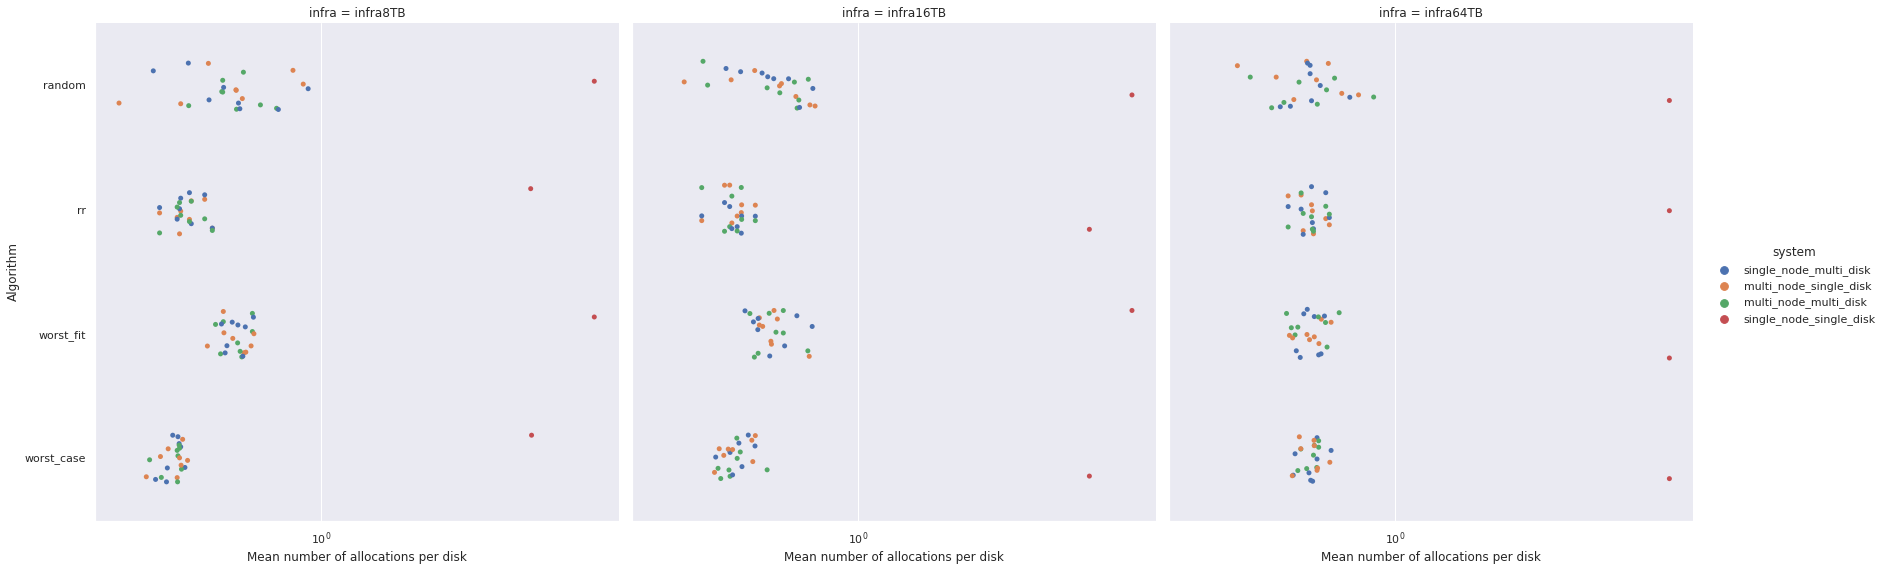

In [33]:
# [7] ---  Mean number of allocations per disk, organised by simulation run and infrastructure.

sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.set_theme(**categorical_theme_disk)

g = sns.catplot(
    data=data_by_disk, kind="strip",
    y="algo", x="disk_mean_nb_alloc",hue="system", col="infra",
    height=8, jitter=0.2, col_order=infra_order, order=algo_order
)
g.set(xscale="log")
g.set_axis_labels("Mean number of allocations per disk", "Algorithm")

[Text(0, 0.5, 'Simulation run'),
 Text(0.5, 0, 'Mean number of allocations per disk')]

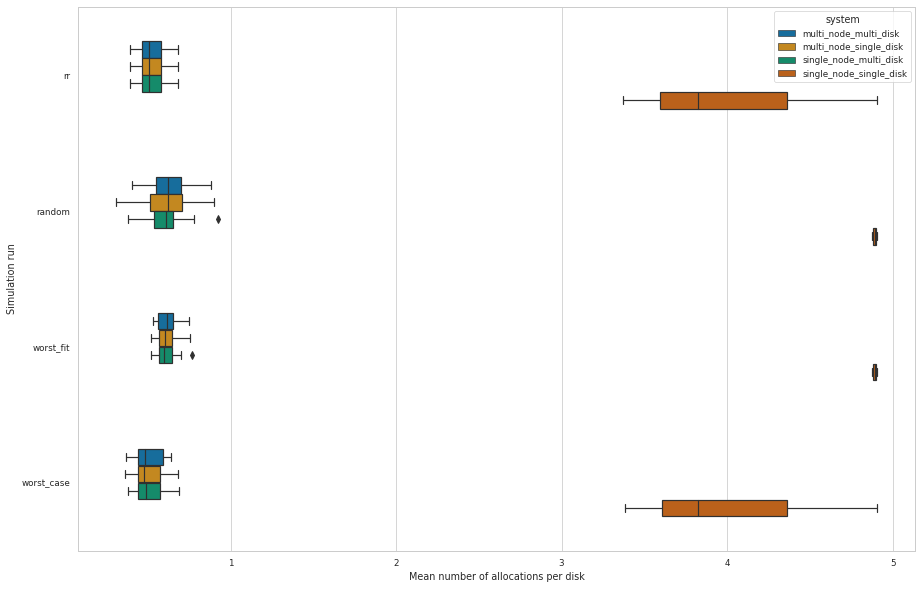

In [55]:
# [8] ---  Mean number of allocations per disk, organised by simulation run and infrastructure.

# sns.set(rc={'figure.figsize':(29.7,21)})
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(**categorical_theme_disk)


g = sns.boxplot(
    data=data_by_disk,
    y="algo", x="disk_mean_nb_alloc", hue="system", 
    dodge=True, width=0.5,
)
#g.set(xscale="log")
g.set(ylabel="Simulation run", xlabel="Mean number of allocations per disk")

[Text(0, 0.5, 'Mean nb. of allocations'), Text(0.5, 0, 'Scheduling algorithm')]

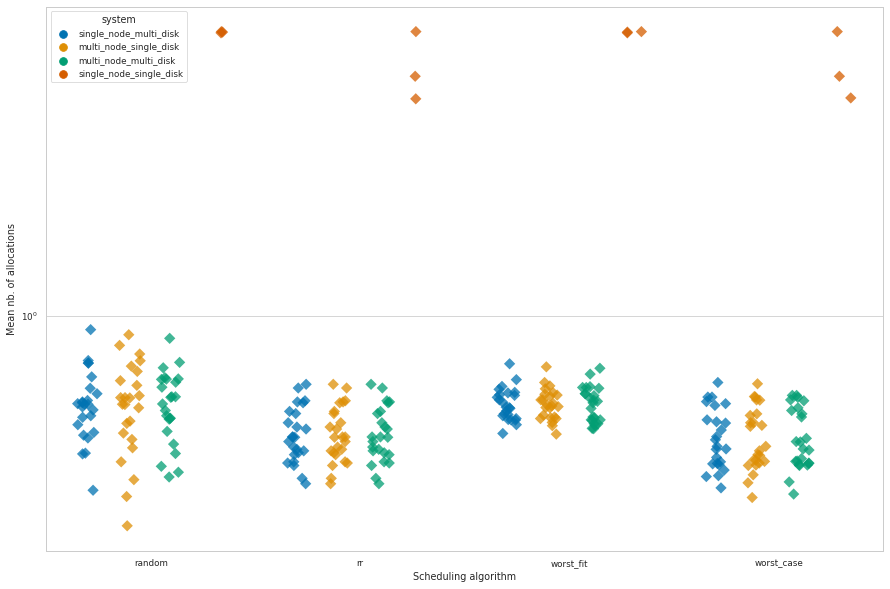

In [35]:
# [9] ---  Mean number of allocations per disk, per algorithm (alt)

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_mean_nb_alloc", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2, order=algo_order
)
g.set(yscale="log")
g.set(ylabel="Mean nb. of allocations", xlabel="Scheduling algorithm")

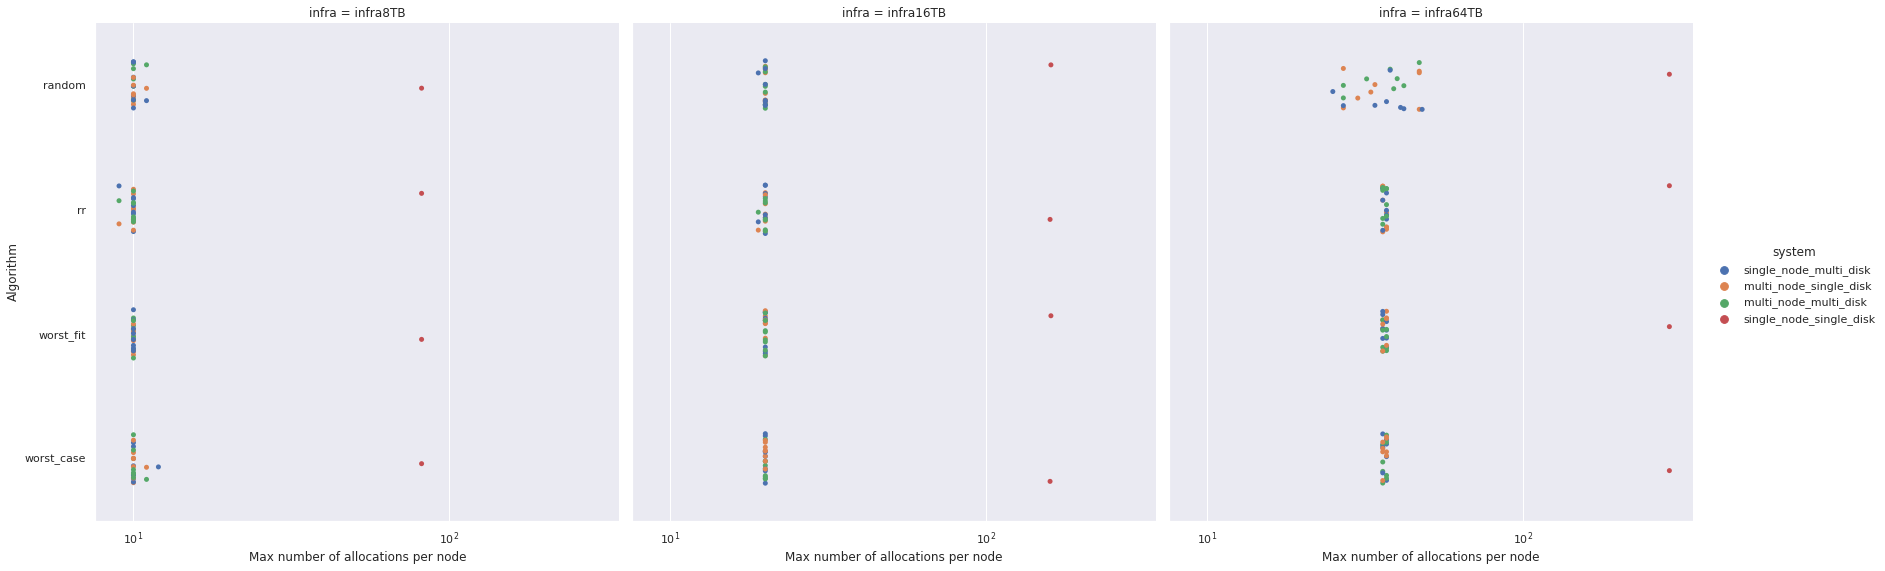

In [38]:
# [10] ---  Max number of allocations per disk, organised by simulation run and infrastructure (1/2)

sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set_theme(**categorical_theme_disk)

g = sns.catplot(
    data=data_by_disk, kind="strip", col="infra",
    y="algo", x="disk_max_nb_alloc",hue="system",
    height=8, jitter=0.2,
    col_order=infra_order, order=algo_order
)
g.set(xscale="log")
g.set_axis_labels("Max number of allocations per node", "Algorithm")

[Text(0, 0.5, 'Algorithm'), Text(0.5, 0, 'Max number of allocations per node')]

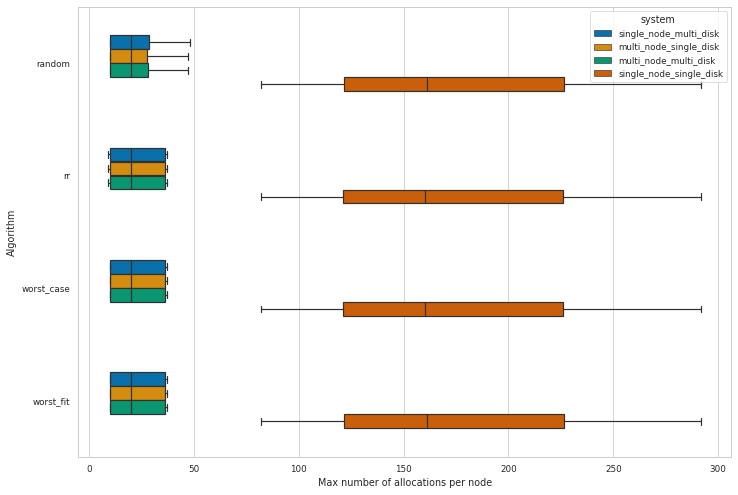

In [39]:
# [11] ---  Max number of allocations per disk, organised by simulation run and infrastructure (2/2)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(**categorical_theme_disk)


g = sns.boxplot(
    data=data_by_disk,
    y="algo", x="disk_max_nb_alloc", hue="system",
    dodge=True, width=0.5, saturation=0.9
)
g.set(ylabel="Algorithm", xlabel="Max number of allocations per node")

[Text(0, 0.5, 'Max nb. of allocations'), Text(0.5, 0, 'Scheduling algorithm')]

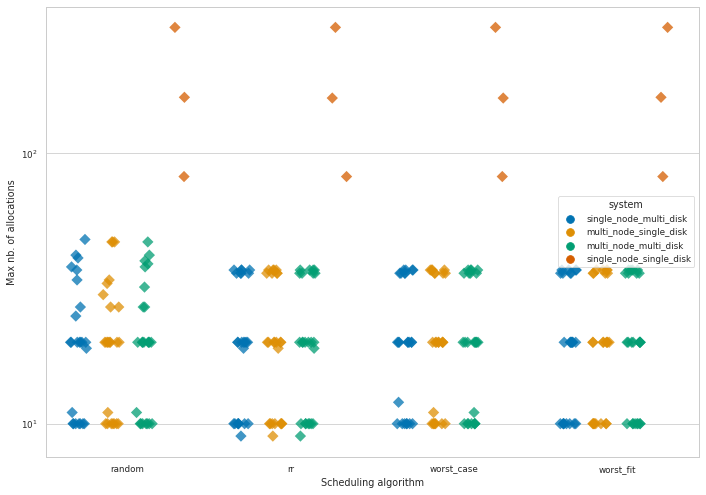

In [40]:
# [12] ---  Max number of allocations per disk, per algorithm (alt)

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_max_nb_alloc", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(yscale="log")
g.set(ylabel="Max nb. of allocations", xlabel="Scheduling algorithm")

[Text(0, 0.5, 'Mean capacity utilisation'),
 Text(0.5, 0, 'Scheduling algorithm')]

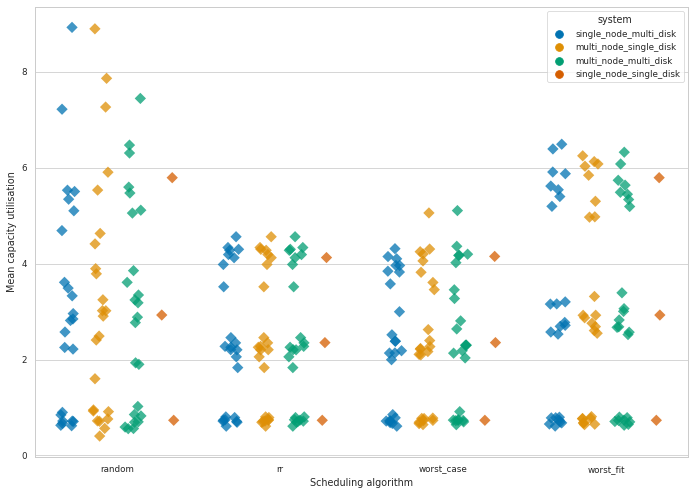

In [41]:
# [13] ---  Mean capacity utilisation per disk, per algorithm

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_mean_cap_percent", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(ylabel="Mean capacity utilisation", xlabel="Scheduling algorithm")

[Text(0, 0.5, 'Max capacity utilisation'),
 Text(0.5, 0, 'Scheduling algorithm')]

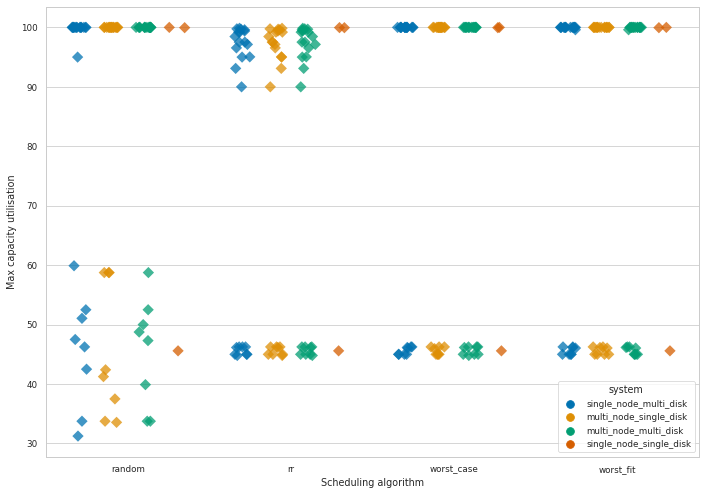

In [42]:
# [14] --- Max capacity utilisation per disk, per algorithm

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_max_cap_percent", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(ylabel="Max capacity utilisation", xlabel="Scheduling algorithm")

In [43]:
data_by_disk_mean_alloc = data_by_disk.sort_values(["disk_mean_nb_alloc",], ascending=True)

[None]

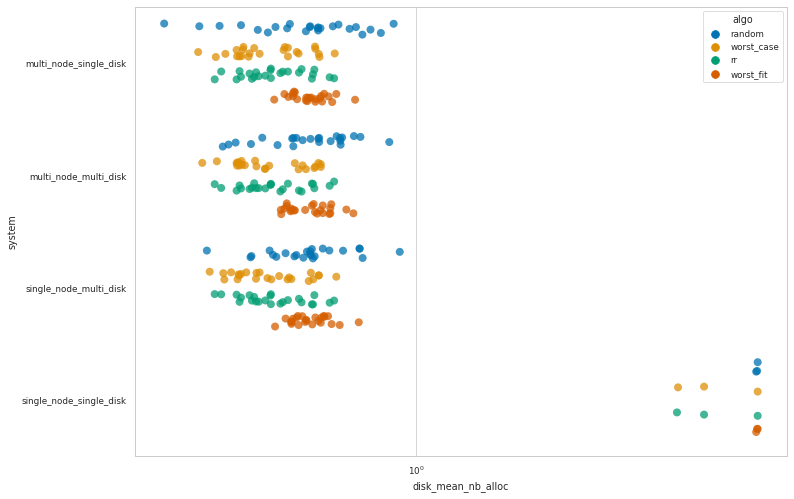

In [44]:
# [15] --- Disk mean nb alloc per run, with hue on Node ID 

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk_mean_alloc,
    y="system", x="disk_mean_nb_alloc",size=8, jitter=0.2, alpha=0.75,
    dodge=True,
    hue="algo",
)
g.set(xscale="log")


# g.xaxis.grid(True, "minor", linewidth=.25)
#g = sns.catplot(x="disk_mean_nb_alloc", y="run_name",
#                hue="node_id",
#                data=data_by_disk_sorted, kind="swarm",
#                alpha=.6, height=21, aspect=29.7/21);

#g.set(xscale="log")
# g.xaxis.grid(True, "minor", linewidth=.25)

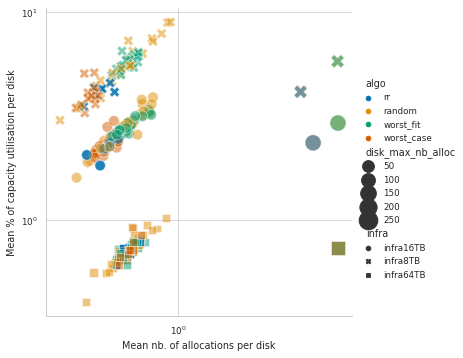

In [64]:
# [16] --- Disk mean nb of alloc compared to disk mean capacity utilisation

sns.set(rc={'figure.figsize':(29.7,21)})
sns.set_theme(**categorical_theme_disk)

infra8_data = data_by_disk[data_by_disk['infra'] == "infra8TB"]

#sns.set_style("whitegrid")
g = sns.relplot(
    x="disk_mean_nb_alloc", 
    y="disk_mean_cap_percent", 
    hue="algo", 
    style="infra",
    size="disk_max_nb_alloc",
    sizes=(100, 400), 
    alpha=.50,
    height=5, 
    data=data_by_disk
)
g.set(
    xscale="log", 
    yscale="log", 
    xlabel="Mean nb. of allocations per disk", 
    ylabel="Mean % of capacity utilisation per disk"
)

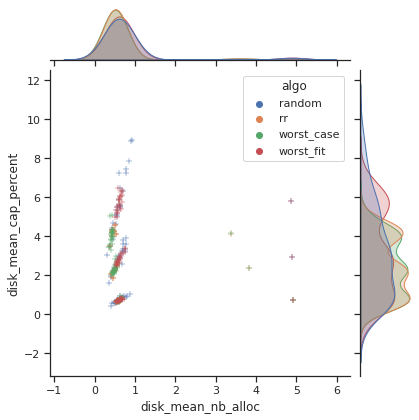

In [46]:
# [16] ---

sns.set_theme(style="ticks")

cmap = sns.hls_palette(n_colors=data_by_disk['algo'].nunique())

g = sns.jointplot(data=data_by_disk, x="disk_mean_nb_alloc", 
                  y="disk_mean_cap_percent", 
                  hue="algo", marker="+")
#g.set(
#    xscale="log", 
#    yscale="log", 
#    xlabel="Mean nb. of allocations per disk", 
#    ylabel="Mean % of capacity utilisation per disk"
#)